## **1. Importing Libraries**

In [370]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## **2. Data Gathering and Reading**

In [371]:
supply = pd.read_csv("/content/drive/MyDrive/Dataset/supply.csv")
supply = pd.DataFrame(supply)

supply.tail()

,DATE,CSUSHPISA,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N
77,01-04-2022,303.4226667,8.7,1734.666667,947300.3333,15286
78,01-07-2022,301.7263333,9.566666667,1610.666667,910346,15306
79,01-10-2022,297.8966667,9.2,1455.333333,870620.6667,14554
80,01-01-2023,.,8.033333333,1424.333333,842559.6667,15053
81,01-04-2023,.,.,.,.,.


In [372]:
demand = pd.read_csv("/content/drive/MyDrive/Dataset/demand.csv")
demand = pd.DataFrame(demand)
demand.tail()

,DATE,CSUSHPISA,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
76,01-01-2022,290.868000,3.822308,63.133333,NaN,433100,24740.480
77,01-04-2022,303.422667,5.266154,57.866667,NaN,449300,25248.476
78,01-07-2022,301.726333,5.623077,56.100000,NaN,468000,25723.941
79,01-10-2022,297.896667,6.664615,58.800000,NaN,479500,26137.992
80,01-01-2023,NaN,6.372308,64.633333,NaN,436800,26465.865


# **3. Data Cleaning**

1. Check Null Values

In [373]:
supply.isnull().sum()

DATE              0
CSUSHPISA         0
MSACSR            0
PERMIT            0
TLRESCONS         0
EVACANTUSQ176N    0
dtype: int64

Supply data has no null values.

In [374]:
demand.isnull().sum()

DATE             0
CSUSHPISA        1
MORTGAGE30US     0
UMCSENT          0
INTDSRUSM193N    7
MSPUS            0
GDP              0
dtype: int64

Demand data has null values in 2 columns. (CSUSHPISA & INTDSRUSM193N)

Filling null values with ffill method as values are in increasing order.
( Filling by mean method would be wrong as data is of 20 years )

In [375]:
demand["CSUSHPISA"].fillna(method = "ffill", inplace = True)
demand["CSUSHPISA"].isnull().sum()

0

In [376]:
demand["INTDSRUSM193N"].fillna(method = "ffill", inplace = True)
demand["INTDSRUSM193N"].isnull().sum()

0

In [377]:
supply['DATE'] = pd.to_datetime(supply['DATE'])
demand['DATE'] = pd.to_datetime(demand['DATE'])

supply = supply.sort_values('DATE')
demand = demand.sort_values('DATE')

merged_data = pd.merge(supply, demand, on='DATE', suffixes=('_supply', '_demand'))

merged_data.dropna(subset=['MSACSR', 'PERMIT', 'TLRESCONS', 'EVACANTUSQ176N', 'MORTGAGE30US', 'GDP', 'UMCSENT'], inplace=True)

imputer = SimpleImputer(strategy='mean')
merged_data['INTDSRUSM193N'] = imputer.fit_transform(merged_data[['INTDSRUSM193N']])

merged_data = merged_data.reset_index(drop=True)

In [378]:
merged_data

,DATE,CSUSHPISA_supply,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,CSUSHPISA_demand,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
0,2003-01-01,129.321,4.2,1806.333333,421328.6667,14908,129.321000,5.840769,79.966667,2.250000,186000,11174.129
1,2003-01-04,131.756,3.833333333,1837.666667,429308.6667,15244,131.756000,5.506923,89.266667,2.166667,191800,11312.766
2,2003-01-07,135.013,3.633333333,1937.333333,458890,15614,135.013000,6.033846,89.300000,2.000000,191900,11566.669
3,2003-01-10,138.8356667,3.966666667,1972.333333,491437.3333,15654,138.835667,5.919286,91.966667,2.000000,198800,11772.234
4,2004-01-01,143.2986667,3.7,1994.666667,506856.3333,15895,143.298667,5.597500,98.000000,2.000000,212700,11923.447
...,...,...,...,...,...,...,...,...,...,...,...,...
76,2022-01-01,290.868,6.233333333,1864,910611,15166,290.868000,3.822308,63.133333,0.250000,433100,24740.480
77,2022-01-04,303.4226667,8.7,1734.666667,947300.3333,15286,303.422667,5.266154,57.866667,0.250000,449300,25248.476
78,2022-01-07,301.7263333,9.566666667,1610.666667,910346,15306,301.726333,5.623077,56.100000,0.250000,468000,25723.941
79,2022-01-10,297.8966667,9.2,1455.333333,870620.6667,14554,297.896667,6.664615,58.800000,0.250000,479500,26137.992


In [379]:
merged_data = merged_data.drop(merged_data.index[80])
merged_data

,DATE,CSUSHPISA_supply,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,CSUSHPISA_demand,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
0,2003-01-01,129.321,4.2,1806.333333,421328.6667,14908,129.321000,5.840769,79.966667,2.250000,186000,11174.129
1,2003-01-04,131.756,3.833333333,1837.666667,429308.6667,15244,131.756000,5.506923,89.266667,2.166667,191800,11312.766
2,2003-01-07,135.013,3.633333333,1937.333333,458890,15614,135.013000,6.033846,89.300000,2.000000,191900,11566.669
3,2003-01-10,138.8356667,3.966666667,1972.333333,491437.3333,15654,138.835667,5.919286,91.966667,2.000000,198800,11772.234
4,2004-01-01,143.2986667,3.7,1994.666667,506856.3333,15895,143.298667,5.597500,98.000000,2.000000,212700,11923.447
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2021-01-10,277.317,6.233333333,1816.666667,837069,14999,277.317000,3.079231,69.900000,0.250000,423600,24349.121
76,2022-01-01,290.868,6.233333333,1864,910611,15166,290.868000,3.822308,63.133333,0.250000,433100,24740.480
77,2022-01-04,303.4226667,8.7,1734.666667,947300.3333,15286,303.422667,5.266154,57.866667,0.250000,449300,25248.476
78,2022-01-07,301.7263333,9.566666667,1610.666667,910346,15306,301.726333,5.623077,56.100000,0.250000,468000,25723.941


In [380]:
merged_data.drop('CSUSHPISA_supply', axis=1, inplace=True)

merged_data.rename(columns={'CSUSHPISA_demand': 'CSUSHPISA'}, inplace=True)
merged_data['CSUSHPISA'] = merged_data['CSUSHPISA'].fillna(merged_data['CSUSHPISA'].mean())

merged_data.head()

,DATE,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,CSUSHPISA,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
0,2003-01-01,4.2,1806.333333,421328.6667,14908,129.321000,5.840769,79.966667,2.250000,186000,11174.129
1,2003-01-04,3.833333333,1837.666667,429308.6667,15244,131.756000,5.506923,89.266667,2.166667,191800,11312.766
2,2003-01-07,3.633333333,1937.333333,458890,15614,135.013000,6.033846,89.300000,2.000000,191900,11566.669
3,2003-01-10,3.966666667,1972.333333,491437.3333,15654,138.835667,5.919286,91.966667,2.000000,198800,11772.234
4,2004-01-01,3.7,1994.666667,506856.3333,15895,143.298667,5.597500,98.000000,2.000000,212700,11923.447


In [381]:
merged_data.rename(columns={'CSUSHPISA':'Home_price_index','MSACSR':'Monthly_supply','PERMIT':'Permit','TLRESCONS':'Total_consumption_spending'\
                  ,'EVACANTUSQ176N':'Housing_inventory','MORTGAGE30US':'30y_mortgage','UMCSENT':'Consumer_sentiment','INTDSRUSM193N':'Interest_rates'\
                  ,'MSPUS':'Median_sales_price','DATE':'Date'},inplace = True)

In [382]:
merged_data

,Date,Monthly_supply,Permit,Total_consumption_spending,Housing_inventory,Home_price_index,30y_mortgage,Consumer_sentiment,Interest_rates,Median_sales_price,GDP
0,2003-01-01,4.2,1806.333333,421328.6667,14908,129.321000,5.840769,79.966667,2.250000,186000,11174.129
1,2003-01-04,3.833333333,1837.666667,429308.6667,15244,131.756000,5.506923,89.266667,2.166667,191800,11312.766
2,2003-01-07,3.633333333,1937.333333,458890,15614,135.013000,6.033846,89.300000,2.000000,191900,11566.669
3,2003-01-10,3.966666667,1972.333333,491437.3333,15654,138.835667,5.919286,91.966667,2.000000,198800,11772.234
4,2004-01-01,3.7,1994.666667,506856.3333,15895,143.298667,5.597500,98.000000,2.000000,212700,11923.447
...,...,...,...,...,...,...,...,...,...,...,...
75,2021-01-10,6.233333333,1816.666667,837069,14999,277.317000,3.079231,69.900000,0.250000,423600,24349.121
76,2022-01-01,6.233333333,1864,910611,15166,290.868000,3.822308,63.133333,0.250000,433100,24740.480
77,2022-01-04,8.7,1734.666667,947300.3333,15286,303.422667,5.266154,57.866667,0.250000,449300,25248.476
78,2022-01-07,9.566666667,1610.666667,910346,15306,301.726333,5.623077,56.100000,0.250000,468000,25723.941


In [383]:
merged_data['Home_price_index'] = merged_data['Home_price_index'].astype(float).round(1)
merged_data['Monthly_supply']=merged_data['Monthly_supply'].astype(float).round(1)
merged_data['Permit']=merged_data['Permit'].astype(float).round(1)
merged_data['Total_consumption_spending']=merged_data['Total_consumption_spending'].astype(float).round(1)
merged_data['Housing_inventory']=merged_data['Housing_inventory'].astype(float).round(1)
merged_data['30y_mortgage']=merged_data['30y_mortgage'].astype(float).round(1)
merged_data['Consumer_sentiment']=merged_data['Consumer_sentiment'].astype(float).round(1)
merged_data['Interest_rates']=merged_data['Interest_rates'].astype(float).round(1)
merged_data['Median_sales_price']=merged_data['Median_sales_price'].astype(float).round(1)
merged_data['GDP']=merged_data['GDP'].astype(float).round(1)

In [384]:
merged_data.columns

Index(['Date', 'Monthly_supply', 'Permit', 'Total_consumption_spending',
       'Housing_inventory', 'Home_price_index', '30y_mortgage',
       'Consumer_sentiment', 'Interest_rates', 'Median_sales_price', 'GDP'],
      dtype='object')

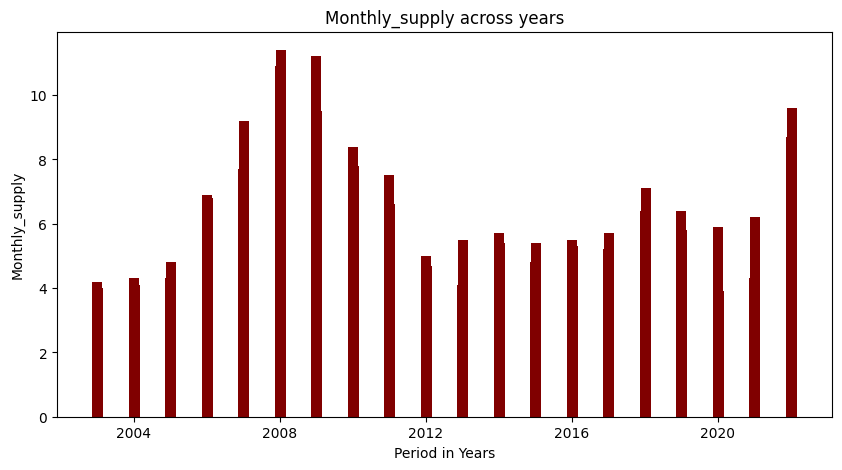

In [385]:
# Graph of Monthly_supply to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["Monthly_supply"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("Monthly_supply")
plt.title("Monthly_supply across years")
plt.show()

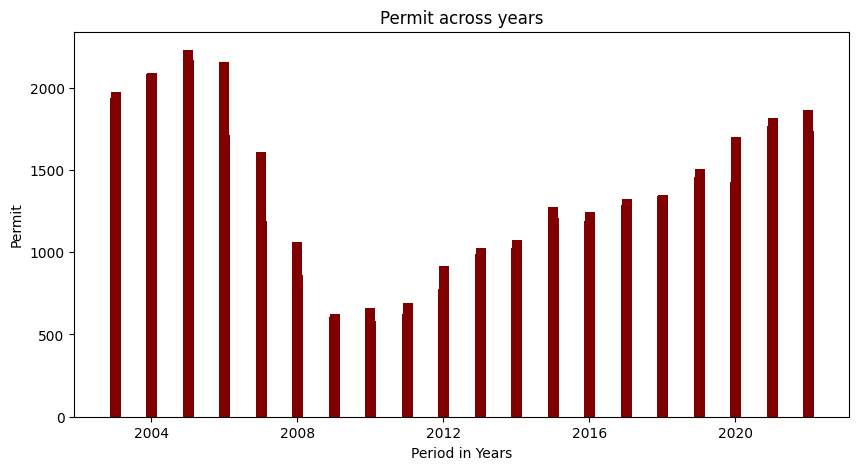

In [386]:
# Graph of Permit to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["Permit"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("Permit")
plt.title("Permit across years")
plt.show()

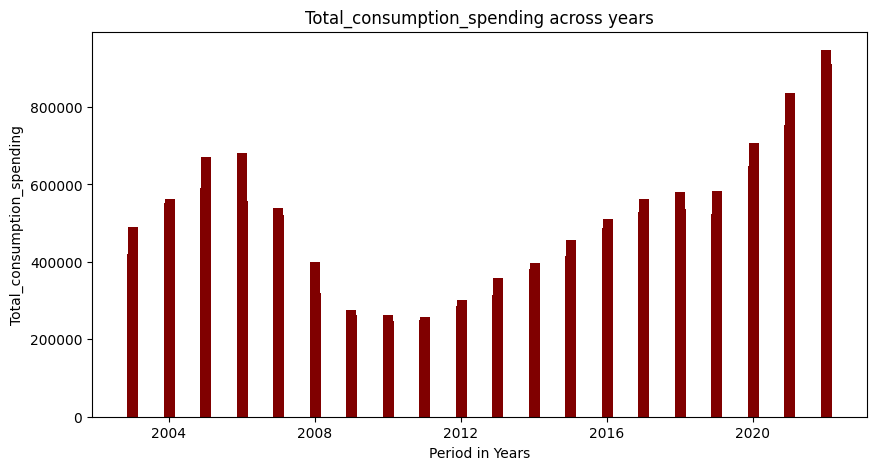

In [387]:
# Graph of Total_consumption_spending to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["Total_consumption_spending"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("Total_consumption_spending")
plt.title("Total_consumption_spending across years")
plt.show()

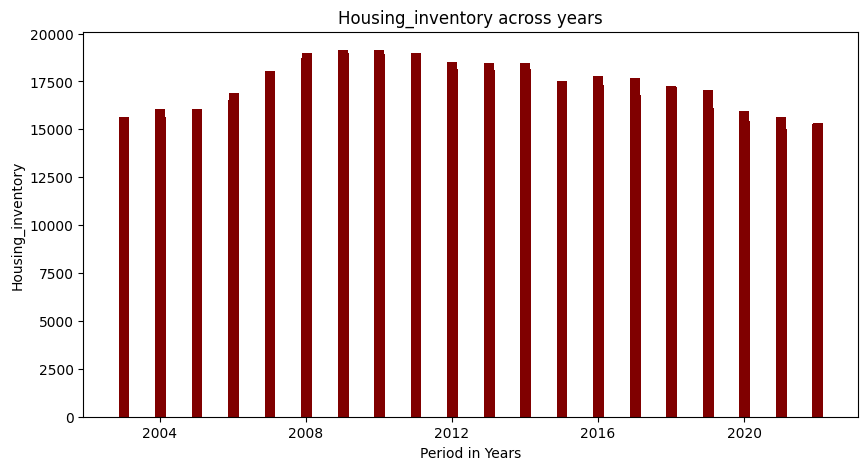

In [388]:
# Graph of Housing_inventory to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["Housing_inventory"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("Housing_inventory")
plt.title("Housing_inventory across years")
plt.show()

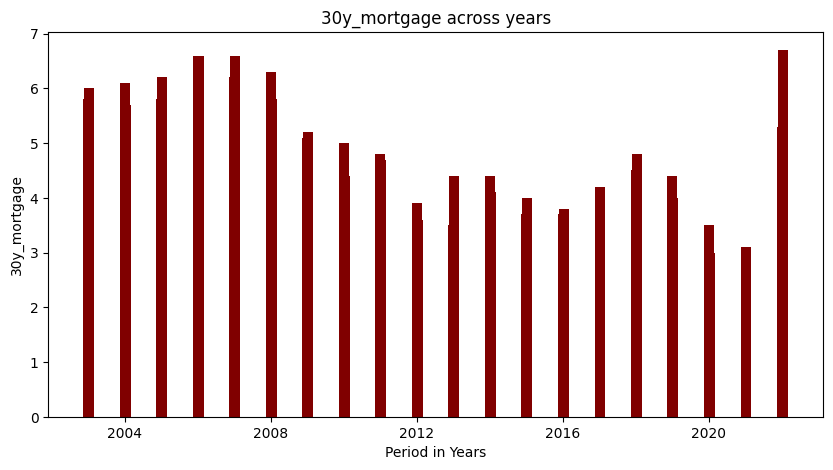

In [389]:
# Graph of 30y_mortgage to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["30y_mortgage"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("30y_mortgage")
plt.title("30y_mortgage across years")
plt.show()

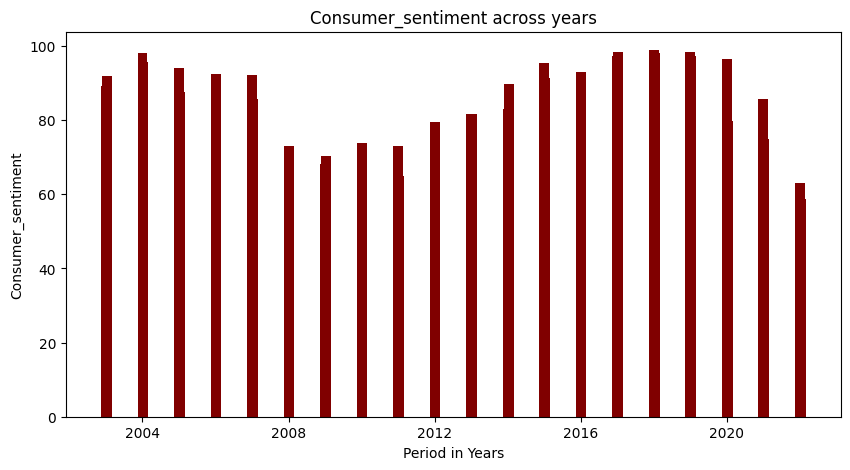

In [390]:
# Graph of Consumer_sentiment to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["Consumer_sentiment"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("Consumer_sentiment")
plt.title("Consumer_sentiment across years")
plt.show()

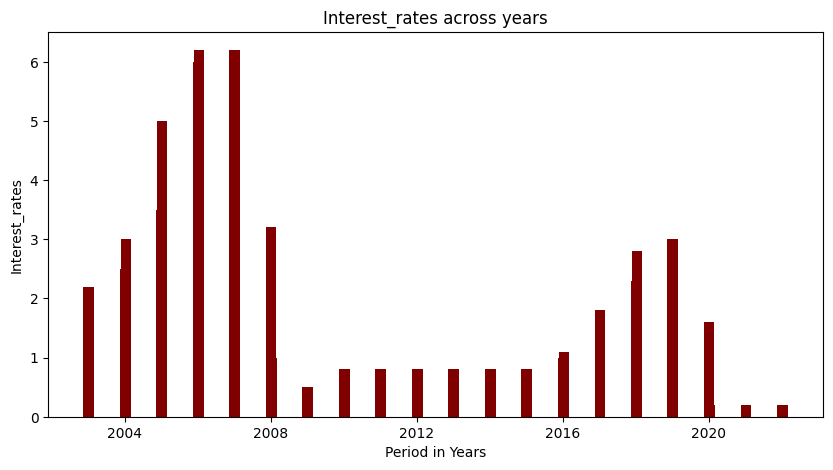

In [391]:
# Graph of Interest_rates to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["Interest_rates"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("Interest_rates")
plt.title("Interest_rates across years")
plt.show()

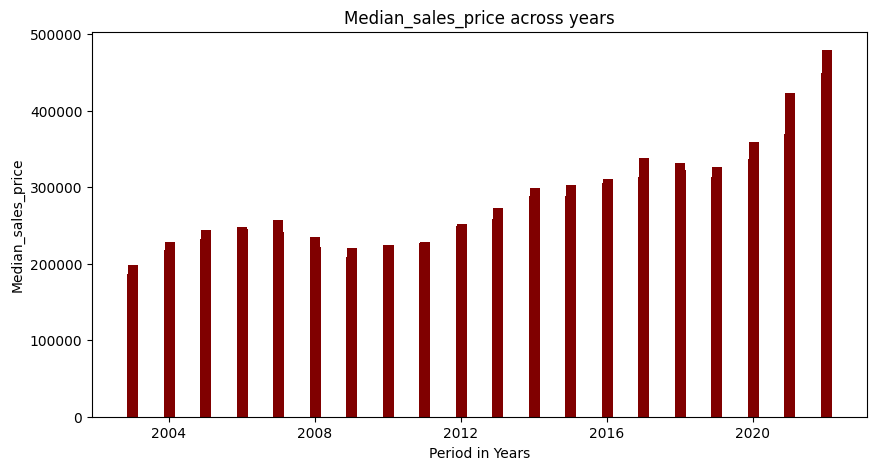

In [392]:
# Graph of Median_sales_price to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["Median_sales_price"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("Median_sales_price")
plt.title("Median_sales_price across years")
plt.show()

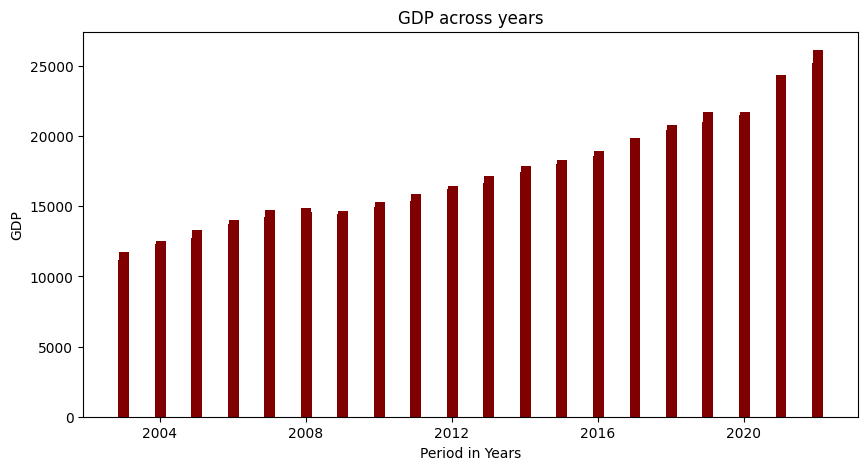

In [393]:
# Graph of GDP to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["GDP"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("GDP")
plt.title("GDP across years")
plt.show()

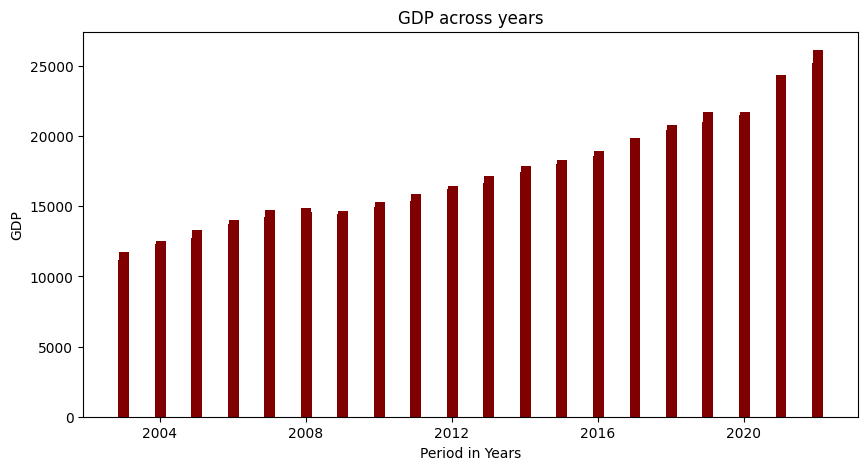

In [394]:
# Graph of GDP to Time

fig = plt.figure(figsize = (10, 5))

plt.bar(merged_data["Date"], merged_data["GDP"], color ='maroon',
        width = 100)

plt.xlabel("Period in Years")
plt.ylabel("GDP")
plt.title("GDP across years")
plt.show()

In [395]:
merged_data.corr()

<ipython-input-395-cc54846d37e8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_data.corr()


,Monthly_supply,Permit,Total_consumption_spending,Housing_inventory,Home_price_index,30y_mortgage,Consumer_sentiment,Interest_rates,Median_sales_price,GDP
Monthly_supply,1.000000,-0.463132,-0.134554,0.440365,0.121914,0.401720,-0.604860,0.065293,0.005409,0.043299
Permit,-0.463132,1.000000,0.762931,-0.834794,0.382234,0.283415,0.435201,0.459392,0.215940,-0.004215
Total_consumption_spending,-0.134554,0.762931,1.000000,-0.822951,0.882138,0.008901,0.144427,0.157300,0.755402,0.580092
Housing_inventory,0.440365,-0.834794,-0.822951,1.000000,-0.592809,0.004379,-0.242017,-0.089371,-0.482770,-0.313321
Home_price_index,0.121914,0.382234,0.882138,-0.592809,1.000000,-0.214152,-0.097781,-0.113494,0.939523,0.855149
30y_mortgage,0.401720,0.283415,0.008901,0.004379,-0.214152,1.000000,-0.097243,0.672541,-0.440788,-0.593071
Consumer_sentiment,-0.604860,0.435201,0.144427,-0.242017,-0.097781,-0.097243,1.000000,0.389223,-0.041424,-0.067770
Interest_rates,0.065293,0.459392,0.157300,-0.089371,-0.113494,0.672541,0.389223,1.000000,-0.331918,-0.444447
Median_sales_price,0.005409,0.215940,0.755402,-0.482770,0.939523,-0.440788,-0.041424,-0.331918,1.000000,0.956029
GDP,0.043299,-0.004215,0.580092,-0.313321,0.855149,-0.593071,-0.067770,-0.444447,0.956029,1.000000


Afrer studying correlation between columns we found out that Home_price_index has few good and few poor correlation features.
**Good Correlation-**
1. Total_consumption spending
2. Median_sales_price
3. GDP
**Weak Correlation -**
1. Permit
2. Housing_inventory
**No Correlation-**
1. Monthly_supply
2. 30y_mortgage
3. Consumer_sentiment
4. Interest_rates


**Making a model after dropping no correlation features.**

In [396]:
df_1 = pd.DataFrame(merged_data)
df_1 = merged_data.drop(["Monthly_supply", "30y_mortgage", "Consumer_sentiment", "Interest_rates"], axis = 1)
df_1

,Date,Permit,Total_consumption_spending,Housing_inventory,Home_price_index,Median_sales_price,GDP
0,2003-01-01,1806.3,421328.7,14908.0,129.3,186000.0,11174.1
1,2003-01-04,1837.7,429308.7,15244.0,131.8,191800.0,11312.8
2,2003-01-07,1937.3,458890.0,15614.0,135.0,191900.0,11566.7
3,2003-01-10,1972.3,491437.3,15654.0,138.8,198800.0,11772.2
4,2004-01-01,1994.7,506856.3,15895.0,143.3,212700.0,11923.4
...,...,...,...,...,...,...,...
75,2021-01-10,1816.7,837069.0,14999.0,277.3,423600.0,24349.1
76,2022-01-01,1864.0,910611.0,15166.0,290.9,433100.0,24740.5
77,2022-01-04,1734.7,947300.3,15286.0,303.4,449300.0,25248.5
78,2022-01-07,1610.7,910346.0,15306.0,301.7,468000.0,25723.9


## **Model Building**

Splitting data

In [397]:
features = ['Monthly_supply', 'Permit', 'Total_consumption_spending',
       'Housing_inventory', '30y_mortgage',
       'Consumer_sentiment', 'Interest_rates', 'Median_sales_price', 'GDP']
target = 'Home_price_index'

X_train, X_test, y_train, y_test = train_test_split(merged_data[features], merged_data[target], test_size=0.2, random_state=42)

In [398]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
}

results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    avg_mse = mse_scores.mean()
    results[model_name] = avg_mse


best_model = min(results, key=results.get)
best_model_instance = models[best_model]

best_model_instance.fit(X_train, y_train)

predictions = best_model_instance.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("Model Selection Results:")
for model, mse_score in results.items():
    print(f"{model}: MSE={mse_score}")

print(f"\nBest Model: {best_model}")
print(f"Best Model MSE on Testing Set: {mse}")

Model Selection Results:
Linear Regression: MSE=14.067154880035162
Decision Tree: MSE=59.0227692307692
Random Forest: MSE=29.85208495769215
Support Vector Regression: MSE=1568.6070939133256

Best Model: Linear Regression
Best Model MSE on Testing Set: 12.239733443842358


After testing the dataset we found out that Linear Regression provides best results.

## **Model Evaluation**

In [399]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)

print("R-squared score:", r2)

R-squared score: 0.985184339413305


The accuracy of our model is 98.518%

## **Finding out best features for predictions**

In [400]:
best_model_instance.fit(X_train, y_train)

coefficients = best_model_instance.coef_

print("Coefficients:")
for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")

Coefficients:
Monthly_supply: 2.8575240651681018
Permit: -0.00726446119978824
Total_consumption_spending: 0.0001429151693121168
Housing_inventory: -0.002029800276987281
30y_mortgage: -1.8905743771614492
Consumer_sentiment: -0.341614179561246
Interest_rates: 2.193995389506185
Median_sales_price: 7.162162517646443e-05
GDP: 0.004016523968332998


## **Report**

Features like Median_sales_price, Monthly_supply, Interest_rates top predictors in our model training.

Features like Consumer_sentiment are weak predictors.

Features like Total_consumption spending, GDP, Permit, Housing_inventory are poor predictors.

Although GDP has better correlation but it is poor predictor.